In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jun 17 12:47:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pip install keras_hist_graph

In [ ]:
import os 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import tensorflow as tf
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten, Input, ZeroPadding2D,InputLayer
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.regularizers import l2
from keras.models import Model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import RMSprop, SGD
from keras.callbacks import History, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras.optimizers import RMSprop
from keras.constraints import unit_norm
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras_hist_graph import plot_history
%matplotlib inline

In [ ]:
pip install livelossplot

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import decode_predictions, preprocess_input, VGG16
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.inception_v3 import InceptionV3
from livelossplot.inputs.keras import PlotLossesCallback

In [ ]:
#set the training path
training_path='/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/training_data'
#set the validation path
validation_path='/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/validation_data'
#set the test path
test_path='/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/test_data'

## **5 breeds**

We are starting with only 5 breeds to see how our transfer model will perform on a reduced dataset

### Setting the data

In [ ]:
breeds=['chow','collie','cairn','dhole','dingo']

As a data augmentation technique, we are going with the rotation 90° technique

In [ ]:
rotation_gen=ImageDataGenerator(rotation_range=90,fill_mode='nearest',rescale=1/255)
rotation_train=rotation_gen.flow_from_directory(training_path, target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20)

Found 553 images belonging to 5 classes.


In [ ]:
validation_gen=ImageDataGenerator(rescale=1/255)
aug_validation=validation_gen.flow_from_directory(validation_path,target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 172 images belonging to 5 classes.


In [ ]:
test_gen=ImageDataGenerator(rescale=1/255)
aug_test=validation_gen.flow_from_directory(test_path,target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 127 images belonging to 5 classes.


In [ ]:
classes=len(breeds)

In our model creation function, we include the Inception V3 model with the **imagenet** weights without adding the top fully connected layers

We are setting the **n_classes** and the **tuning_layers** as arguments of the function

- **n_classes**: manage the number of classes we want in the output

- **tuning_layers**: manages the layers we need to ignore in order to get to the convolutional layer

In [ ]:
def create_model(n_classes,tuning_layers):

  #Import the pre-trained Inception model without the fully connected layers on top
  conv_inception=InceptionV3(weights='imagenet', 
                  include_top = False,
                  input_shape = (224,224, 3))

  #setting the fine-tuning loop
  if tuning_layers==0:
    conv_inception.trainable=False
  else:
    for layer in conv_inception.layers[:-tuning_layers]:
      layer.trainable=False

  #bootstrapping a new top_model into the pre-trained model

  model=Sequential()
  model.add(conv_inception)
  model.add(Flatten())
  model.add(Dense(512, activation='relu',input_shape=(None,51200)))
  model.add(Dropout(0.3))
  model.add(Dense(n_classes,activation='softmax'))

  model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
  
  return model

### Without using fine-tuning

In [ ]:
conv_inception_v3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
inception_0=create_model(n_classes=classes, tuning_layers=0)

In [ ]:
inception_0.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2565      
Total params: 48,020,261
Trainable params: 26,217,477
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
plot_tun0=PlotLossesCallback()

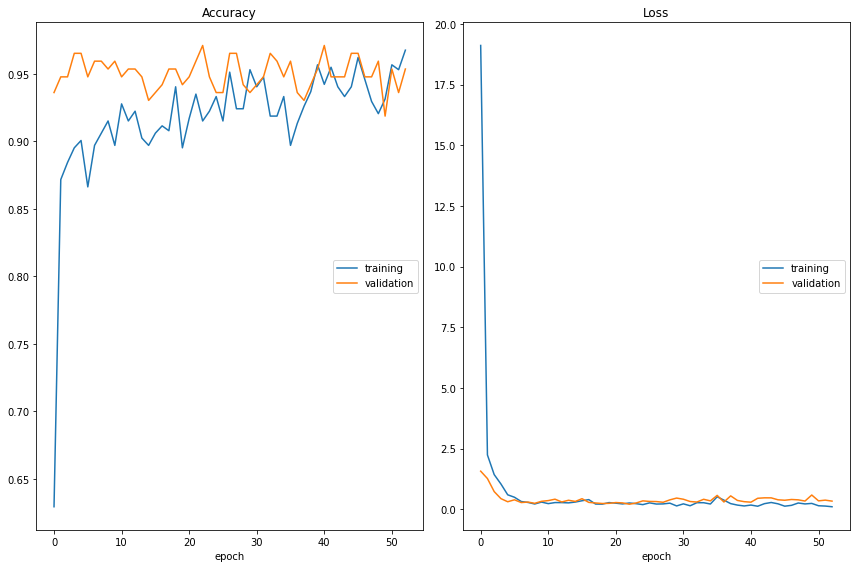

Accuracy
	training         	 (min:    0.629, max:    0.967, cur:    0.967)
	validation       	 (min:    0.919, max:    0.971, cur:    0.953)
Loss
	training         	 (min:    0.100, max:   19.109, cur:    0.100)
	validation       	 (min:    0.204, max:    1.566, cur:    0.332)
Epoch 00053: early stopping


In [ ]:
history_inception_0=inception_0.fit(rotation_train,batch_size=20, epochs=1000, verbose=2,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v3/5_breeds/no_fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun0
              ])

In [ ]:
inception_0=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v3/5_breeds/no_fine_tuning')

In [ ]:
inception_0.evaluate(aug_test)

7/7 [==============================] - 33s 5s/step - loss: 0.1883 - acc: 0.9291


[0.188338041305542, 0.9291338324546814]

Great!!! we have 92% accuracy for the 5 breeds model.

big improvment of our prediction status since we had 62% with our scrach CNN network

### keeping last convolutional layer trainable

Next, we are going to fine tune our inception model with two strategies: 

1. First, we are going to re-train the last convolutional layer with our dataset

2. then, we will go up to the next convoltional layer 

In [ ]:
inception_1=create_model(n_classes=classes, tuning_layers=12)

In order to get to the last convolutional layer, we need to go up to 12 layers 

In [ ]:
inception_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 2565      
Total params: 48,020,261
Trainable params: 26,611,205
Non-trainable params: 21,409,056
_________________________________________________________________


In [ ]:
plot_tun1=PlotLossesCallback()

In [ ]:
rotation_train.reset()
aug_validation.reset()

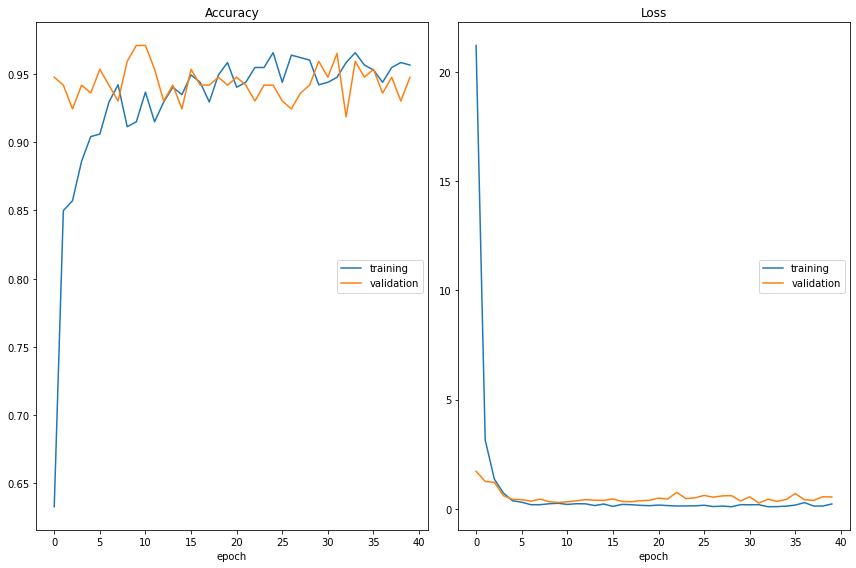

Accuracy
	training         	 (min:    0.633, max:    0.966, cur:    0.957)
	validation       	 (min:    0.919, max:    0.971, cur:    0.948)
Loss
	training         	 (min:    0.099, max:   21.217, cur:    0.226)
	validation       	 (min:    0.267, max:    1.725, cur:    0.547)
Epoch 00040: early stopping


In [ ]:
history_inception_1=inception_1.fit(rotation_train,batch_size=20, epochs=1000, verbose=2,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v3/5_breeds/fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun1
              ]
    )

In [ ]:
aug_test.reset()

In [ ]:
inception_1=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v3/5_breeds/fine_tuning')

In [ ]:
inception_1.evaluate(aug_test)

7/7 [==============================] - 2s 57ms/step - loss: 0.2629 - acc: 0.9449


[0.2628844678401947, 0.9448819160461426]

re-training the last convolutional layer did improve the results, as we get from **92%** to **94%**

### 2 convoltional layers trainable

In [ ]:
inception_2=create_model(n_classes=classes, tuning_layers=14)

In [ ]:
inception_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 2565      
Total params: 48,020,261
Trainable params: 26,611,973
Non-trainable params: 21,408,288
_________________________________________________________________


In [ ]:
plot_tun2=PlotLossesCallback()

In [ ]:
rotation_train.reset()
aug_validation.reset()

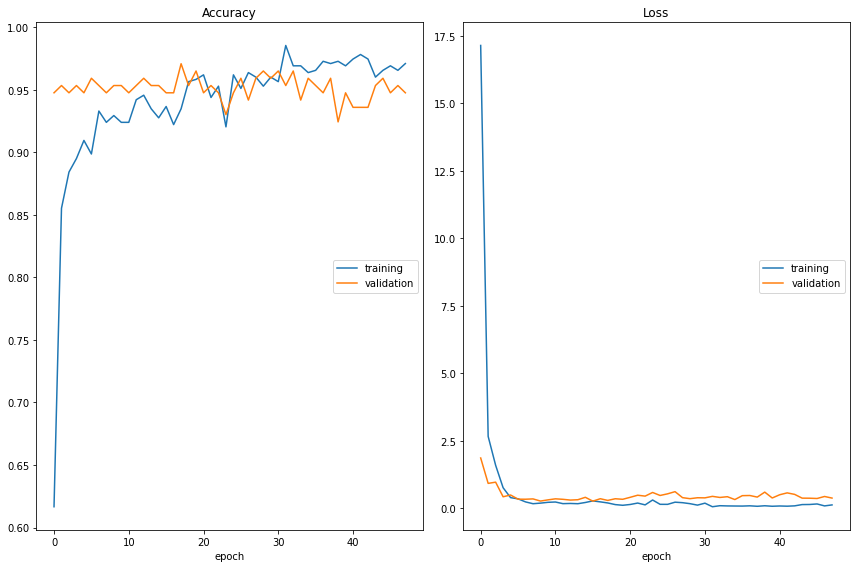

Accuracy
	training         	 (min:    0.617, max:    0.986, cur:    0.971)
	validation       	 (min:    0.924, max:    0.971, cur:    0.948)
Loss
	training         	 (min:    0.063, max:   17.146, cur:    0.130)
	validation       	 (min:    0.270, max:    1.869, cur:    0.383)
Epoch 00048: early stopping


In [ ]:
history_inception_2=inception_2.fit(rotation_train,batch_size=20, epochs=1000, verbose=2,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v3/5_breeds/fine_tuning2',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun2
              ]
    )

In [ ]:
aug_test.reset()

In [ ]:
inception_2=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v3/5_breeds/fine_tuning2')

In [ ]:
inception_2.evaluate(aug_test)

7/7 [==============================] - 1s 54ms/step - loss: 0.2792 - acc: 0.9449


[0.27918756008148193, 0.9448819160461426]

results are quite the same for both fine-tuning strategies in order of accuracies, with lower loss value for the first strategy 

### Comparing models with heatmap

Next, we are comparing the results of the three models with or scrach CNN model 

For this we are using heatmaps along with our confusion matrix

In [ ]:
def plot_heatmap(true_labels,pred_labels, class_names, ax, title):
    g=sns.heatmap(
        confusion_matrix(true_labels, pred_labels), 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap='coolwarm',
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

    return g



In [ ]:
scratch_cnn=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/rotation_data_5_breeds')

In [ ]:
aug_test.reset()

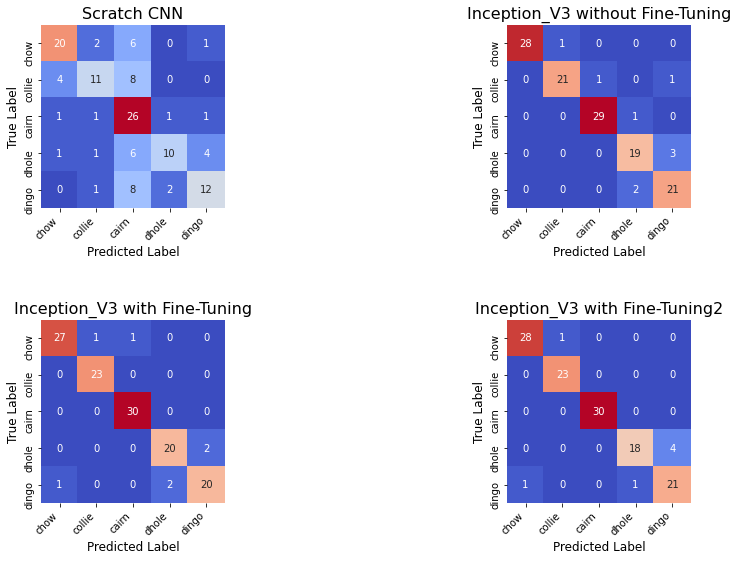

In [ ]:
classes=aug_test.class_indices.keys()
fig, axes = plt.subplots(
                     ncols=2,
                     nrows=2,
                     figsize=(15, 6))

ax1, ax2, ax3, ax4 = axes.flatten()

plot_heatmap(aug_test.classes, np.argmax(scratch_cnn.predict(aug_test), axis=1), classes, ax1, title="Scratch CNN")  
aug_test.reset()  
plot_heatmap(aug_test.classes, np.argmax(inception_0.predict(aug_test), axis=1), classes, ax2, title="Inception_V3 without Fine-Tuning")  
aug_test.reset()  
plot_heatmap(aug_test.classes, np.argmax(inception_1.predict(aug_test), axis=1), classes, ax3, title="Inception_V3 with Fine-Tuning")
aug_test.reset()
plot_heatmap(aug_test.classes, np.argmax(inception_2.predict(aug_test), axis=1), classes, ax4, title="Inception_V3 with Fine-Tuning2")  
aug_test.reset()   

fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

We have a big improvment regarding the scrach model

Lets see if we do well also with a higher number of classes

# 20 Breeds

In [ ]:
breeds=['basset', 'borzoi', 'Walker_hound', 'bluetick', 'beagle', 'black and tan_coonhound', 'English_foxhound', 'Irish_wolfhound', 'redbone', 'bloodhound', 'Italian_greyhound',
 'whippet', 'Scottish_deerhound', 'Weimaraner', 'Bedlington_terrier', 'American_Staffordshire_terrier', 'Saluki', 'Staffordshire_bullterrier', 'Norwegian_elkhound', 'Ibizan_hound',]

## Setting the data

In [ ]:
rotation_gen=ImageDataGenerator(rotation_range=90,fill_mode='nearest',rescale=1/255)
rotation_train=rotation_gen.flow_from_directory(training_path, target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20)

Found 2314 images belonging to 20 classes.


In [ ]:
validation_gen=ImageDataGenerator(rescale=1/255)
aug_validation=validation_gen.flow_from_directory(validation_path,target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 712 images belonging to 20 classes.


In [ ]:
test_gen=ImageDataGenerator(rescale=1/255)
aug_test=validation_gen.flow_from_directory(test_path,target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 534 images belonging to 20 classes.


## No fine tuning

In [ ]:
inception_0_20breeds=create_model(n_classes=20,tuning_layers=0)

In [ ]:
plot_tun0_20=PlotLossesCallback()

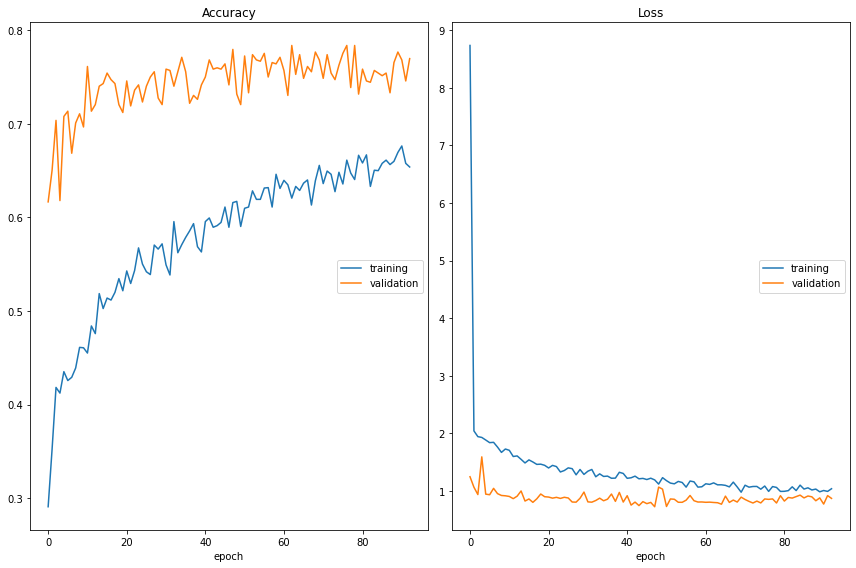

Accuracy
	training         	 (min:    0.291, max:    0.676, cur:    0.654)
	validation       	 (min:    0.617, max:    0.784, cur:    0.770)
Loss
	training         	 (min:    0.978, max:    8.736, cur:    1.039)
	validation       	 (min:    0.726, max:    1.592, cur:    0.871)
Epoch 00093: early stopping


In [ ]:
history_inception0_20breeds=inception_0_20breeds.fit(rotation_train,batch_size=20, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v3/20_breeds/no_fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun0_20
              ]
    )

In [ ]:
aug_test.reset()

In [ ]:
inception_0_20breeds.evaluate(aug_test)

27/27 [==============================] - 151s 6s/step - loss: 0.7517 - acc: 0.7697


[0.7517170310020447, 0.7696629166603088]

## Fine tuning

In [ ]:
inception_1_20breeds=create_model(n_classes=20,tuning_layers=12)

In [ ]:
plot_tun1_20=PlotLossesCallback()

In [ ]:
rotation_train.reset()
aug_validation.reset()

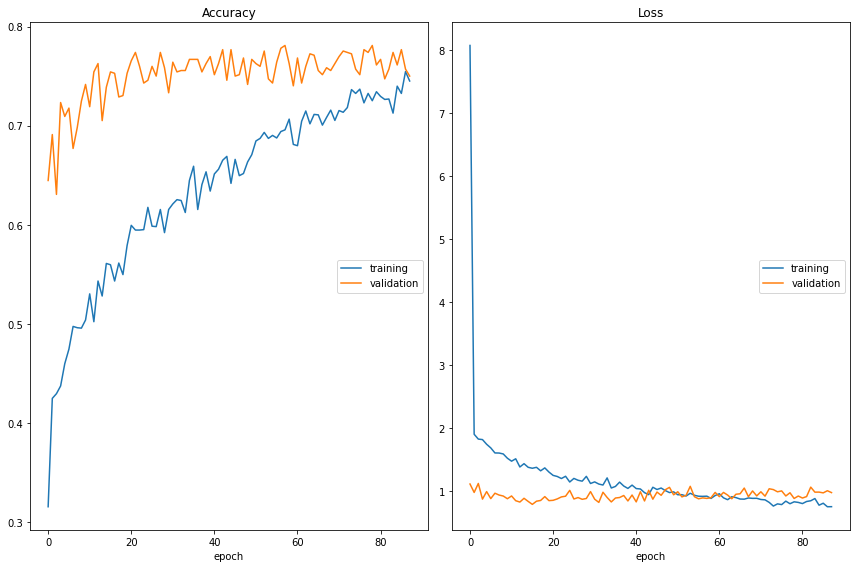

Accuracy
	training         	 (min:    0.315, max:    0.755, cur:    0.745)
	validation       	 (min:    0.631, max:    0.781, cur:    0.750)
Loss
	training         	 (min:    0.756, max:    8.075, cur:    0.756)
	validation       	 (min:    0.793, max:    1.125, cur:    0.980)
Epoch 00088: early stopping


In [ ]:
history_inception1_20breeds=inception_1_20breeds.fit(rotation_train,batch_size=20, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v3/20_breeds/fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun1_20
              ]
    )

In [ ]:
aug_test.reset()

In [ ]:
inception_1_20breeds.evaluate(aug_test)

27/27 [==============================] - 2s 58ms/step - loss: 0.7900 - acc: 0.7865


[0.790000855922699, 0.7865168452262878]

## Fine tuning: 2 convolutional layers

In [ ]:
inception_2_20breeds=create_model(n_classes=20,tuning_layers=14)

In [ ]:
plot_tun2_20=PlotLossesCallback()

In [ ]:
rotation_train.reset()
aug_validation.reset()

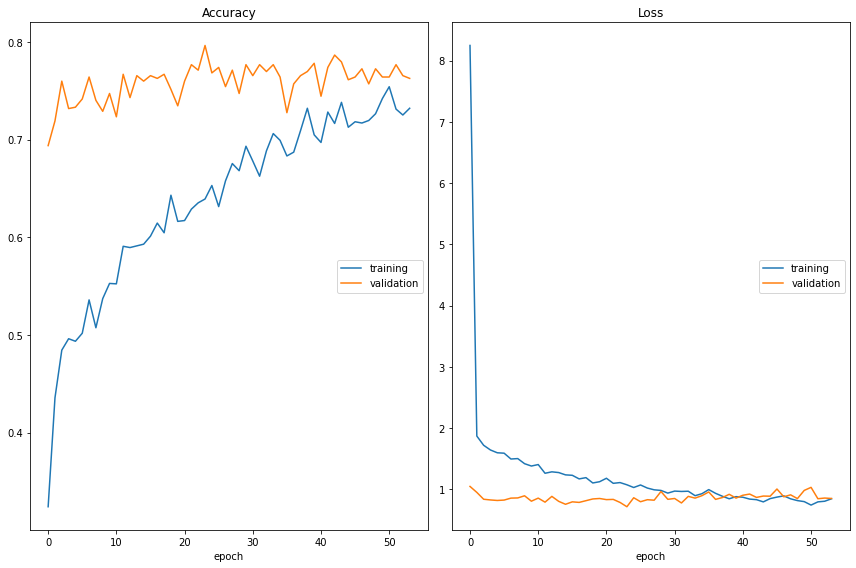

Accuracy
	training         	 (min:    0.324, max:    0.754, cur:    0.732)
	validation       	 (min:    0.694, max:    0.796, cur:    0.763)
Loss
	training         	 (min:    0.741, max:    8.248, cur:    0.844)
	validation       	 (min:    0.714, max:    1.045, cur:    0.849)
Epoch 00054: early stopping


In [ ]:
history_inception2_20breeds=inception_2_20breeds.fit(rotation_train,batch_size=20, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v3/20_breeds/fine_tuning2',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun2_20
              ]
    )

In [ ]:
aug_test.reset()

In [ ]:
inception_2_20breeds.evaluate(aug_test)

27/27 [==============================] - 2s 57ms/step - loss: 0.8200 - acc: 0.7828


[0.8199875950813293, 0.7827715277671814]

Similaraly to the 5 breeds model, we have an improvment of our performance using the fine tuning process

# 120 Breeds

Moving on to the final model

we are performing the same steps with : 

- No fine tuning

- Fine tuning 1

- Fine tuning 2

## Setting the data

In [ ]:
rotation_gen=ImageDataGenerator(rotation_range=90,fill_mode='nearest',rescale=1/255)
rotation_train=rotation_gen.flow_from_directory(training_path, target_size=(224, 224),classes=os.listdir(training_path),
                              class_mode='categorical', batch_size=20)

In [ ]:
validation_gen=ImageDataGenerator(rescale=1/255)
aug_validation=validation_gen.flow_from_directory(validation_path,target_size=(224, 224),classes=os.listdir(training_path),
                              class_mode='categorical', batch_size=20, shuffle=False)

In [ ]:
test_gen=ImageDataGenerator(rescale=1/255)
aug_test=validation_gen.flow_from_directory(test_path,target_size=(224, 224),classes=os.listdir(training_path),
                              class_mode='categorical', batch_size=20, shuffle=False)

## No Fine tuning

In [ ]:
inception_0_120breeds=create_model(n_classes=119,tuning_layers=0)

In [ ]:
plot_tun0_120=PlotLossesCallback()

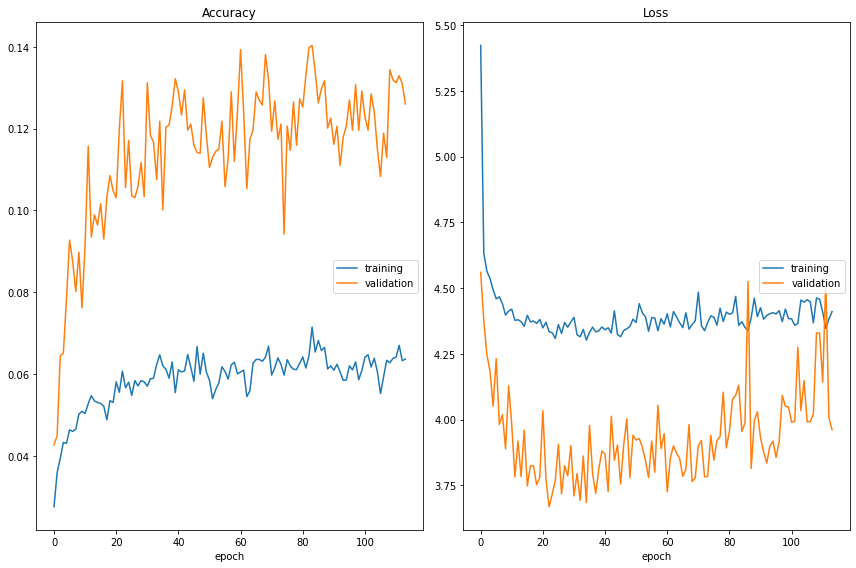

Accuracy
	training         	 (min:    0.028, max:    0.071, cur:    0.064)
	validation       	 (min:    0.043, max:    0.140, cur:    0.126)
Loss
	training         	 (min:    4.302, max:    5.422, cur:    4.411)
	validation       	 (min:    3.669, max:    4.560, cur:    3.961)
Epoch 00114: early stopping


In [ ]:
history_inception0_120breeds=inception_0_120breeds.fit(rotation_train,batch_size=20, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v3/120_breeds/no_fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun0_120
              ]
    )

In [ ]:
aug_test.reset()

In [ ]:
inception_0_120breeds.evaluate(aug_test)

152/152 [==============================] - 9s 56ms/step - loss: 3.9009 - acc: 0.1376


[3.900873899459839, 0.13763582706451416]

With no Fine_tuning we get similar results to the scrach CNN model

## fine tuning

In order to get to the last convolutional layer, we need to move up 12 layers 

In [ ]:
inception_1_120breeds=create_model(n_classes=119,tuning_layers=12)

In [ ]:
plot_tun1_120=PlotLossesCallback()

In [ ]:
rotation_train.reset()

In [ ]:
aug_validation.reset()

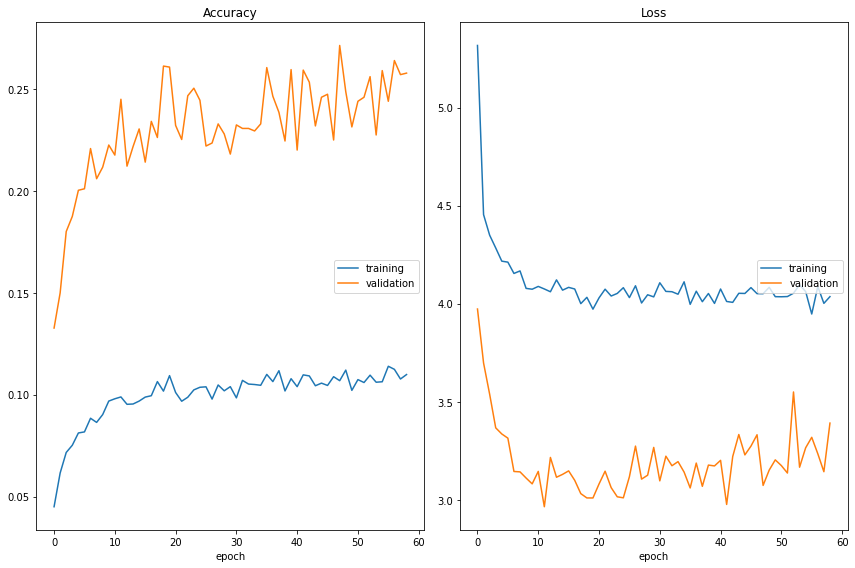

Accuracy
	training         	 (min:    0.045, max:    0.114, cur:    0.110)
	validation       	 (min:    0.133, max:    0.271, cur:    0.258)
Loss
	training         	 (min:    3.947, max:    5.316, cur:    4.036)
	validation       	 (min:    2.965, max:    3.973, cur:    3.391)
Epoch 60/1000
433/665 [==================>...........] - ETA: 48s - loss: 4.1730 - acc: 0.1035

In [ ]:
history_inception1_120breeds=inception_1_120breeds.fit(rotation_train,batch_size=20, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v3/120_breeds/fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun1_120
              ]
    )

In [ ]:
inception_1_120breeds=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v3/120_breeds/fine_tuning')

In [ ]:
aug_test.reset()

In [ ]:
inception_1_120breeds.evaluate(aug_test)

152/152 [==============================] - 1507s 10s/step - loss: 3.2228 - acc: 0.2651


[3.2227749824523926, 0.26506420969963074]

here is a small improvment with our first fine_tuning strategy

## fine tuning2

In [ ]:
inception_2_120breeds=create_model(n_classes=119,tuning_layers=14)

In [ ]:
plot_tun2_120=PlotLossesCallback()

In [ ]:
rotation_train.reset()

In [ ]:
aug_validation.reset()

In [ ]:
history_inception2_120breeds=inception_2_120breeds.fit(rotation_train,batch_size=20, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v3/120_breeds/fine_tuning2',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun2_120
              ]
    )

In [ ]:
inception_2_120breeds=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v3/120_breeds/fine_tuning2')

In [ ]:
aug_test.reset()

In [ ]:
inception_2_120breeds.evaluate(aug_test)

152/152 [==============================] - 675s 4s/step - loss: 2.7340 - acc: 0.3836


[2.7340030670166016, 0.38360223174095154]

As Final result, moving on to the next convolutional layer did improve so much better the results 